# Import

In [1]:
import os
import sys
import types
from itertools import islice
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.core.debugger import set_trace
from PIL import Image
from torch.utils.data import DataLoader

In [2]:
sys.path.append('../../')

In [3]:
from fiducial_detect.data import *
from fiducial_detect.models import *

# Utility

In [4]:
def save_checkpoint(model, optimizer, metrics, file_checkpoint):
    file_checkpoint.parent.mkdir(exist_ok=True)
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'metrics': metrics},
               file_checkpoint)

In [5]:
def load_checkpoint(model, optimizer, file_checkpoint):
    checkpoint = torch.load(file_checkpoint)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    metrics = checkpoint['metrics']
    return model, optimizer, metrics

In [6]:
def train(model, dl, loss, metrics, optimizer, device):
    m, total_items = dict.fromkeys(metrics.keys(), 0), 0
    
    # Train for an epoch
    model.train()
    for X, y in dl:
        X, y = X.to(device), y.to(device)
        
        # Optimize
        optimizer.zero_grad()
        y_hat = model(X)
        l = loss(y_hat, y)
        l.backward()
        optimizer.step()
        
        # Get metrics scaled by batch size
        for key, metric in metrics.items():
            m[key] += metric(y_hat, y)*X.shape[0] # Scale by batch size
           
        # Track total number of items
        total_items += X.shape[0]
        
    # Get mean of metrics
    for key, metric in metrics.items():
        m[key] /= total_items
        
    return m

In [7]:
def validate(model, dl, loss, metrics, optimizer, device):
    m, total_items = dict.fromkeys(metrics.keys(), 0), 0
    
    # Validate
    model.eval()
    with torch.no_grad():
        for X, y in dl:
            X, y = X.to(device), y.to(device)

            y_hat = model(X)

            # Get metrics scaled by batch size
            for key, metric in metrics.items():
                m[key] += metric(y_hat, y)*X.shape[0] # Scale by batch size

            # Track total number of items
            total_items += X.shape[0]

        # Get mean of metrics
        for key, metric in metrics.items():
            m[key] /= total_items

    return m

# Metrics

In [8]:
class MetricAccuracy():
    def __call__(self, y_hat, y):
        return (y_hat.argmax(dim=1) == y).float().mean().item()

In [9]:
class MetricErrorRate():
    def __call__(self, y_hat, y):
        return 1 - MetricAccuracy()(y_hat, y)

# Train

In [10]:
# Config
batch_size = 28
num_workers = 4
pin_memory = True
num_batches = 20
num_epochs = 500
lr = 1e-3
schedule = False

# Device
device = torch.device('cuda')

# Loss
loss = nn.functional.cross_entropy

# Metrics
metrics = {}
metrics['loss'] = lambda y_hat, y: loss(y_hat, y).item()
metrics['err'] = MetricErrorRate()

# Checkpoint metric
metric_checkpoint = 'err'

# Model
in_channels  = 1
out_channels = 5
layout_encoder = [[[48,5,2,2]],
                  [[48,3,1,1],[48,3,2,1]],
                  [[60,3,1,1],[60,3,2,1]],
                  [[72,3,1,1],[144,3,2,1]]]
model = UNET(get_encoder(in_channels, layout_encoder), out_channels)
model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [11]:
tfms_trn = Compose([Resize((512, 384)), 
                    Normalize((0, 1), (-1, 1)),
                    RandomContrast((0.5, 1.5), 1, 0.33),
                    RandomBrightness((-0.5, 0.5), 0, 0.33),
                    RandomBlur((0, 1.5), 0.50, 0.50),
                    Random(Noise((-0.25, 0.25), 0, 0.1), 0.9),
                    Random(RandomGrad((-0.5, 0.5))     , 0.9),
                    Clip((-1,1)),
                    ToTensor()])

dl_trn = IsliceDataloader(num_batches,
                          SyntheticMaskDataSet(tfms=tfms_trn), 
                          batch_size=batch_size,
                          num_workers=num_workers,
                          pin_memory=pin_memory, 
                          worker_init_fn=lambda wid: np.random.seed(np.mod(torch.initial_seed() + wid, 2**32)))

In [12]:
tfms_val = Compose([Resize((512, 384)), 
                    Normalize((0, 1), (-1, 1)),
                    ToTensor()])

dl_val = DataLoader(RealMaskDataSet(Path('../../data/ground_truth'), tfms=tfms_val), 
                    batch_size=batch_size,
                    num_workers=num_workers,
                    pin_memory=pin_memory, 
                    worker_init_fn=lambda wid: np.random.seed(np.mod(torch.initial_seed() + wid, 2**32)))

<IPython.core.display.Javascript object>


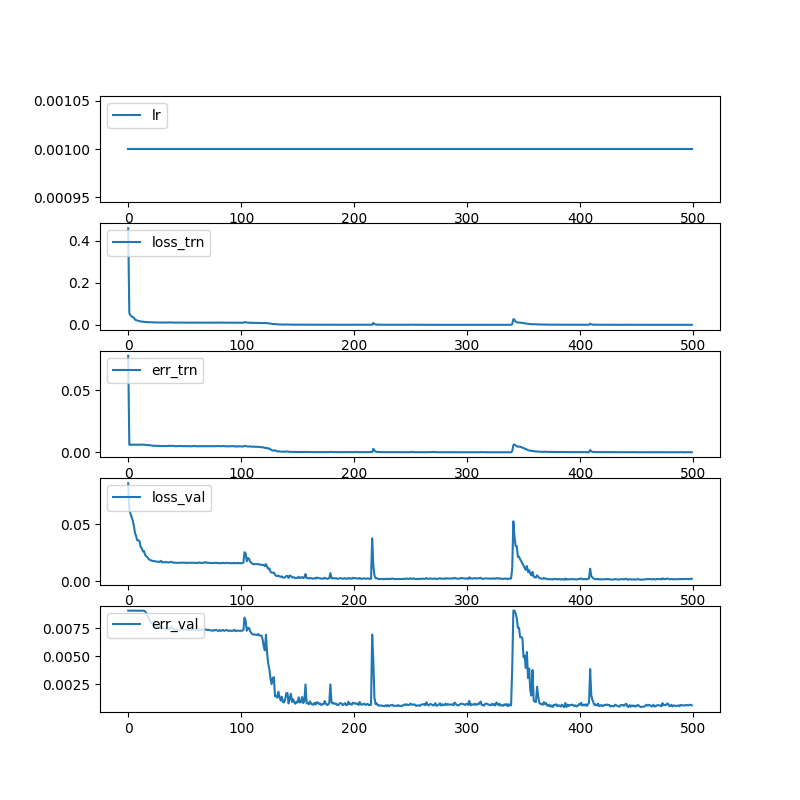

            lr   loss_trn    err_trn   loss_val    err_val
0      0.00100    0.45856    0.07764    0.08653    0.00909 - err decreased; checkpointing...
1      0.00100    0.05544    0.00612    0.06286    0.00909
2      0.00100    0.04583    0.00637    0.05977    0.00909
3      0.00100    0.03990    0.00610    0.05646    0.00909
4      0.00100    0.03725    0.00622    0.05359    0.00909
5      0.00100    0.03420    0.00636    0.04903    0.00909
6      0.00100    0.02629    0.00625    0.04269    0.00909
7      0.00100    0.02252    0.00615    0.03975    0.00909
8      0.00100    0.02079    0.00627    0.03602    0.00909
9      0.00100    0.01866    0.00617    0.03599    0.00909
10     0.00100    0.01772    0.00622    0.03545    0.00909
11     0.00100    0.01711    0.00646    0.03014    0.00909
12     0.00100    0.01535    0.00615    0.02906    0.00909
13     0.00100    0.01523    0.00633    0.02628    0.00909 - err decreased; checkpointing...
14     0.00100    0.01456    0.00622    0.02649

116    0.00100    0.00942    0.00449    0.01468    0.00686 - err decreased; checkpointing...
117    0.00100    0.00912    0.00433    0.01446    0.00685 - err decreased; checkpointing...
118    0.00100    0.00887    0.00416    0.01426    0.00686
119    0.00100    0.00906    0.00422    0.01438    0.00652 - err decreased; checkpointing...
120    0.00100    0.00874    0.00399    0.01403    0.00589 - err decreased; checkpointing...
121    0.00100    0.00836    0.00377    0.01320    0.00552 - err decreased; checkpointing...
122    0.00100    0.00784    0.00349    0.01487    0.00692
123    0.00100    0.00858    0.00370    0.01257    0.00522 - err decreased; checkpointing...
124    0.00100    0.00715    0.00308    0.01091    0.00434 - err decreased; checkpointing...
125    0.00100    0.00744    0.00321    0.01105    0.00383 - err decreased; checkpointing...
126    0.00100    0.00594    0.00247    0.00813    0.00302 - err decreased; checkpointing...
127    0.00100    0.00499    0.00194    0.007

240    0.00100    0.00070    0.00027    0.00173    0.00055
241    0.00100    0.00062    0.00024    0.00182    0.00056
242    0.00100    0.00062    0.00023    0.00174    0.00053
243    0.00100    0.00062    0.00024    0.00188    0.00061
244    0.00100    0.00068    0.00026    0.00187    0.00062
245    0.00100    0.00073    0.00027    0.00204    0.00071
246    0.00100    0.00068    0.00026    0.00186    0.00062
247    0.00100    0.00059    0.00023    0.00233    0.00069
248    0.00100    0.00065    0.00025    0.00197    0.00064
249    0.00100    0.00062    0.00024    0.00185    0.00065
250    0.00100    0.00066    0.00025    0.00243    0.00077
251    0.00100    0.00153    0.00058    0.00193    0.00068
252    0.00100    0.00093    0.00034    0.00192    0.00065
253    0.00100    0.00071    0.00027    0.00237    0.00071
254    0.00100    0.00067    0.00026    0.00182    0.00065
255    0.00100    0.00057    0.00022    0.00170    0.00056
256    0.00100    0.00062    0.00024    0.00181    0.000

378    0.00100    0.00118    0.00044    0.00169    0.00065
379    0.00100    0.00094    0.00035    0.00185    0.00070
380    0.00100    0.00093    0.00034    0.00135    0.00052
381    0.00100    0.00086    0.00032    0.00185    0.00061
382    0.00100    0.00113    0.00043    0.00153    0.00058
383    0.00100    0.00110    0.00038    0.00130    0.00050
384    0.00100    0.00106    0.00038    0.00179    0.00068
385    0.00100    0.00106    0.00039    0.00143    0.00054
386    0.00100    0.00086    0.00032    0.00120    0.00046 - err decreased; checkpointing...
387    0.00100    0.00086    0.00032    0.00222    0.00082
388    0.00100    0.00087    0.00033    0.00118    0.00046
389    0.00100    0.00086    0.00032    0.00176    0.00068
390    0.00100    0.00084    0.00031    0.00137    0.00055
391    0.00100    0.00074    0.00028    0.00162    0.00063
392    0.00100    0.00081    0.00030    0.00162    0.00063
393    0.00100    0.00087    0.00033    0.00178    0.00068
394    0.00100    0.00

In [13]:
%matplotlib notebook

# Training loop
df_metrics = pd.DataFrame(columns=['lr'] + 
                                  [str(key+'_trn') for key in metrics.keys()] +
                                  [str(key+'_val') for key in metrics.keys()])
m_checkpoint = np.inf # Initialize to arbitrarily high value
fig, axs = plt.subplots(df_metrics.shape[1], 1, figsize=(8,8))
for num_epoch in range(num_epochs):    
    # Train
    m_trn = train(model, dl_trn, loss, metrics, optimizer, device)
    
    # Validate
    m_val = validate(model, dl_val, loss, metrics, optimizer, device)
    
    # Step scheduler
    if schedule:
        scheduler.step(m_trn['loss'])
    
    # Store metrics
    df_metrics.loc[num_epoch, 'lr'] = np.mean([p['lr'] for p in optimizer.param_groups])
    for key, val in m_trn.items(): df_metrics.loc[num_epoch, key+'_trn'] = val
    for key, val in m_val.items(): df_metrics.loc[num_epoch, key+'_val'] = val
    
    # Print metrics
    print(df_metrics.iloc[[num_epoch]].to_string(header=num_epoch == 0,
                                                 float_format=lambda x: f'{x:10.5f}',
                                                 col_space=3), end='')
    
    # Checkpoint
    if m_val[metric_checkpoint] < m_checkpoint:
        print(f' - {metric_checkpoint} decreased; checkpointing...', end='')
        save_checkpoint(model, optimizer, df_metrics, Path('checkpoints/best.pth'))
        m_checkpoint = m_val[metric_checkpoint]
        
    # Print newline
    print()
    
    # Plot stuff
    for idx, key in enumerate(df_metrics.columns):
        axs[idx].clear()
        axs[idx].plot(np.arange(num_epoch+1), df_metrics[key], label=key)
        axs[idx].legend(loc='upper left')
    fig.canvas.draw()
    
%matplotlib inline

# Test

In [ ]:
X, y = next(iter(dl_trn))
X, y = X.to(device), y.to(device)

In [ ]:
model.eval()
with torch.no_grad():
    y_hat = model(X)

In [ ]:
idx = 2

In [ ]:
plt.imshow(X[idx,0,:,:].cpu().detach())

In [ ]:
plt.imshow(y_hat.argmax(dim=1).cpu().detach()[idx], vmin=0, vmax=4)

In [ ]:
plt.imshow(y.cpu().detach().numpy()[idx], vmin=0, vmax=4)

In [ ]:
files_img = [p for p in Path('data').glob('*.png') if not p.name.endswith('mask.png')]

In [ ]:
idx = 10
img = Image.open(files_img[idx])

In [ ]:
img = img.resize((512, 384))

In [ ]:
img = np.array(img)

In [ ]:
img = img.astype(np.float32)

In [ ]:
img /= img.max()

In [ ]:
img = normalize(img, [0, 1], [-1, 1])

In [ ]:
img.min(), img.max()

In [ ]:
plt.imshow(img, vmin=-1, vmax=1, cmap='gray')

In [ ]:
img = torch.tensor(img)[None][None]
img.shape

In [ ]:
img = img.to(device)

In [ ]:
model.eval()
with torch.no_grad():
    mask = model(img)

In [ ]:
mask = mask.argmax(dim=1).cpu().detach().numpy()[0]

In [ ]:
plt.imshow(mask, vmin=0, vmax=4)